# Image Segmentation

In [0]:
#Run once per session
import os
!pip install -q feather-format kornia pyarrow wandb nbdev fastprogress fastai2 fastcore --upgrade 
!pip install torch==1.3.1
!pip install torchvision==0.4.2
!pip install Pillow==6.2.1 --upgrade
os._exit(00)

# Libraries

In [1]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

# Dataset

We will be using `llg-MRI-segmentation` dataset. This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.

The images were obtained from The Cancer Imaging Archive (TCIA).

They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.
Tumor genomic clusters and patient data is provided in data.csv file.

In [2]:
from zipfile import ZipFile

In [3]:
url = "/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation.zip"

def zip_extract(fname, dest):
    zipfile.ZipFile(fname, mode='r').extractall(dest)

path = untar_data(url, extract_func=zip_extract, dest="/home/ubuntu/datasets/brain-MRI-segmentation/")

In [4]:
#path = untar_data("/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation.zip", dest="/home/ubuntu/datasets/")
path

Path('/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation')

In [5]:
!ls -l $path

total 4
drwxr-xr-x 112 ubuntu ubuntu 4096 Feb 25 09:28 kaggle_3m


In [6]:
!ls $path/kaggle_3m

data.csv	       TCGA_DU_7018_19911220  TCGA_FG_A4MU_20030903
README.md	       TCGA_DU_7019_19940908  TCGA_FG_A60K_20040224
TCGA_CS_4941_19960909  TCGA_DU_7294_19890104  TCGA_HT_7473_19970826
TCGA_CS_4942_19970222  TCGA_DU_7298_19910324  TCGA_HT_7475_19970918
TCGA_CS_4943_20000902  TCGA_DU_7299_19910417  TCGA_HT_7602_19951103
TCGA_CS_4944_20010208  TCGA_DU_7300_19910814  TCGA_HT_7605_19950916
TCGA_CS_5393_19990606  TCGA_DU_7301_19911112  TCGA_HT_7608_19940304
TCGA_CS_5395_19981004  TCGA_DU_7302_19911203  TCGA_HT_7616_19940813
TCGA_CS_5396_20010302  TCGA_DU_7304_19930325  TCGA_HT_7680_19970202
TCGA_CS_5397_20010315  TCGA_DU_7306_19930512  TCGA_HT_7684_19950816
TCGA_CS_6186_20000601  TCGA_DU_7309_19960831  TCGA_HT_7686_19950629
TCGA_CS_6188_20010812  TCGA_DU_8162_19961029  TCGA_HT_7690_19960312
TCGA_CS_6290_20000917  TCGA_DU_8163_19961119  TCGA_HT_7692_19960724
TCGA_CS_6665_20010817  TCGA_DU_8164_19970111  TCGA_HT_7693_19950520
TCGA_CS_6666_20011109  TCGA_DU_8165_19970205  TCGA_HT_7694_19

^ Each directory belongs to a patient.

In [7]:
!ls $path/kaggle_3m/TCGA_CS_4941_19960909

TCGA_CS_4941_19960909_10_mask.tif  TCGA_CS_4941_19960909_20.tif
TCGA_CS_4941_19960909_10.tif	   TCGA_CS_4941_19960909_21_mask.tif
TCGA_CS_4941_19960909_11_mask.tif  TCGA_CS_4941_19960909_21.tif
TCGA_CS_4941_19960909_11.tif	   TCGA_CS_4941_19960909_22_mask.tif
TCGA_CS_4941_19960909_12_mask.tif  TCGA_CS_4941_19960909_22.tif
TCGA_CS_4941_19960909_12.tif	   TCGA_CS_4941_19960909_23_mask.tif
TCGA_CS_4941_19960909_13_mask.tif  TCGA_CS_4941_19960909_23.tif
TCGA_CS_4941_19960909_13.tif	   TCGA_CS_4941_19960909_2_mask.tif
TCGA_CS_4941_19960909_14_mask.tif  TCGA_CS_4941_19960909_2.tif
TCGA_CS_4941_19960909_14.tif	   TCGA_CS_4941_19960909_3_mask.tif
TCGA_CS_4941_19960909_15_mask.tif  TCGA_CS_4941_19960909_3.tif
TCGA_CS_4941_19960909_15.tif	   TCGA_CS_4941_19960909_4_mask.tif
TCGA_CS_4941_19960909_16_mask.tif  TCGA_CS_4941_19960909_4.tif
TCGA_CS_4941_19960909_16.tif	   TCGA_CS_4941_19960909_5_mask.tif
TCGA_CS_4941_19960909_17_mask.tif  TCGA_CS_4941_19960909_5.tif
TCGA_CS_4941_19960909_17.tif	   TC

^ This specific patient has 23 MR scan images and their masks in .tif format.

In [8]:
tt = pd.read_csv(f"{path}/kaggle_3m/data.csv")

In [9]:
tt.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [10]:
os.chdir(path)

Since we can not specify a pattern inside the `get_image_files` function, we will use `glob.glob` with pattern to get non-mask files and then convert them into a list of Path objects

In [11]:
fnames = glob.glob("/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation/kaggle_3m/**/*_[0-9]*[0-9].tif", recursive=True)

In [12]:
len(fnames)

3929

In [13]:
fnames[:5]

['/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_33.tif',
 '/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_26.tif',
 '/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_9.tif',
 '/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_22.tif',
 '/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_38.tif']

In [14]:
# apply Path to every item in list
f_names = [Path(item) for item in fnames]

In [15]:
f_names[:5]

[Path('/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_33.tif'),
 Path('/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_26.tif'),
 Path('/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_9.tif'),
 Path('/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_22.tif'),
 Path('/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_38.tif')]

In [16]:
len(fnames), len(f_names)

(3929, 3929)

In [17]:
o = f_names[3]
o.stem, o.suffix

('TCGA_DU_5874_19950510_22', '.tif')

In [18]:
#get_msk = lambda o: str(Path(o).parent/f'{Path(o).stem}_mask{Path(o).suffix}')  # would work with fnames
get_msk = lambda o: o.parent/f'{o.stem}_mask{o.suffix}'

In [19]:
fnames[3], get_msk(f_names[3])

('/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_22.tif',
 Path('/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_22_mask.tif'))

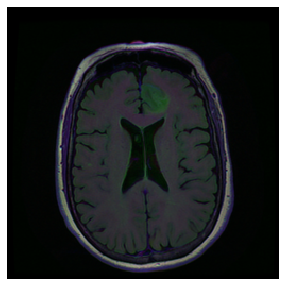

In [20]:
img_fn = f_names[3]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

Now let's grab our y's. They live in the `labels` folder and are denoted by a `_mask`

In [21]:
get_msk(img_fn)

Path('/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_22_mask.tif')

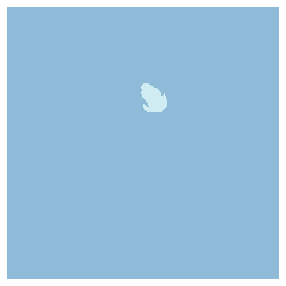

In [22]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=0.5)

Now if we look at what our mask actually is, we can see it's a giant array of pixels:

In [23]:
tensor(msk)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

Where each one represents a class that we can find in `codes.txt`. Let's make a vocabulary with it

In [24]:
str(dir(msk))

"['_Image__transformer', '__array_interface__', '__class__', '__copy__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__signature__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_bypass_type', '_close_exclusive_fp_after_loading', '_copy', '_crop', '_do_crop_pad', '_dump', '_ensure_mutable', '_exif', '_expand', '_new', '_open_args', '_repr_png_', '_show_args', '_size', '_tensor_cls', 'alpha_composite', 'aspect', 'category', 'close', 'convert', 'copy', 'create', 'crop', 'crop_pad', 'draft', 'effect_spread', 'entropy', 'filter', 'flip_lr', 'format', 'format_description', 'frombytes', 'fromstring', 'getbands', 'getbbox', 'getchannel', 'getcolors', 'getdata', 'getexif', 'getextrema', 

In [25]:
np.unique(np.array(msk.getdata()))

array([  0, 255])

In [26]:
codes = np.unique(np.array(msk.getdata()))

We need a split function that will split from our list of valid filenames we grabbed earlier. Let's try making our own.

In [27]:
# def FileSplitter(fname):
#     "Split `items` depending on the value of `mask`."
#     valid = Path(fname).read().split('\n') 
#     def _func(x): return x.name in valid
#     def _inner(o, **kwargs): return FuncSplitter(_func)(o)
#     return _inner

This takes in our filenames, and checks for all of our filenames in all of our items in our validation filenames

# Transfer Learning between DataSets

Jeremy popularized the idea of image resizing:
* Train on smaller sized images
* Eventually get larger and larger
* Transfer Learning loop

This first round we will train at half the image size

In [28]:
sz = msk.shape; sz

(256, 256)

In [29]:
half = tuple(int(x/2) for x in sz); half

(128, 128)

In [30]:
llg = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=f_names,
                   splitter=RandomSplitter(0.2),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

In [35]:
# dls = llg.dataloaders(f_names, bs=4)
dls = llg.dataloaders(source=f_names, do_batch=None)

TypeError: 'list' object is not callable

In [36]:
f_names[:5]

[Path('/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_33.tif'),
 Path('/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_26.tif'),
 Path('/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_9.tif'),
 Path('/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_22.tif'),
 Path('/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_38.tif')]

In [37]:
path

Path('/home/ubuntu/datasets/brain-MRI-segmentation/lgg-mri-segmentation')

In [39]:
# dls = llg.dataloaders(path/'kaggle_3m/**/', bs=4)
dls = llg.dataloaders(path/'kaggle_3m/TCGA_DU_*/', bs=4)

TypeError: 'list' object is not callable

Let's look at a batch, and look at all the classes between codes 1 and 30 (ignoring `Animal` and `Wall`)

In [253]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

Lastly let's make our vocabulary a part of our `DataLoaders`, as our loss function needs to deal with the `Void` label

In [28]:
dls.vocab = codes

Now we need a methodology for grabbing that particular code from our output of numbers. Let's make everything into a dictionary

In [255]:
# name2id = {v:k for k,v in enumerate(codes)}

In [256]:
# name2id

Awesome! Let's make an accuracy function

In [257]:
# void_code = name2id['Void']

For segmentation, we want to squeeze all the outputted values to have it as a matrix of digits for our segmentation mask. From there, we want to match their argmax to the target's mask for each pixel and take the average

In [247]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  #mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

# Model

## U-Net

![](http://deeplearning.net/tutorial/_images/unet.jpg)

U-Net allows us to look at pixel-wise representations of our images through sizing it down and then blowing it bck up into a high resolution image. The first part we call an "encoder" and the second a "decoder"

On the image, the authors of the UNET paper describe the arrows as "denotions of different operations"

We have a special `unet_learner`. Something new is we can pass in a configuration(`unet_config`) where we can declare a few things!

* Blur/blur final: avoid checkerboard artifacts
* Self attention: A self-attention layer
* y_range: Last activations go through a sigmoid for rescaling
* Last cross - Cross-connection with the direct model input
* Bottle - Bottlenck or not on that cross
* Activation function
* Norm type

Let's make a `unet_learner` that uses some of the new state of the art techniques. Specifically:

* Self-attention layers: `self_attention = True`
* Mish activation function: `act_cls = Mish`

In [248]:
config = unet_config(self_attention=True, act_cls=Mish)

Along with this we will use the `Ranger` activation function

In [249]:
opt = ranger

In [250]:
learn = unet_learner(dls, resnet34, metrics=acc_camvid, config=config,
                     opt_func=opt)

NameError: name 'dls' is not defined

In [258]:
# learn.summary()

If we do a `learn.summary` we can see this blow-up trend, and see that our model came in frozen. Let's find a learning rate

In [259]:
# learn.lr_find()

In [260]:
# lr = 1e-3

With our new optimizer, we will also want to use a different fit function, called `fit_flat_cos`

In [261]:
# learn.fit_flat_cos(10, slice(lr))

In [262]:
# learn.save('stage-1')
# learn.load('stage-1');

In [263]:
# learn.show_results(max_n=4, figsize=(12,6))

Let's unfreeze the model and decrease our learning rate by 4 (Rule of thumb)

In [264]:
# lrs = slice(lr/400, lr/4)

In [265]:
# lr, lrs

In [266]:
# learn.unfreeze()

And train for a bit more

In [267]:
# learn.fit_flat_cos(12, lrs)

Now let's save that model away

In [268]:
# learn.save('stage_2')

And look at a few results

In [269]:
# learn.show_results(max_n=4, figsize=(18,8))

# Inference

Let's take a look at how to do inference with `test_dl`

Let's do the first five pictures

In [48]:
# compared to pred, this offers batch input for inference
# dl = learn.dls.test_dl(fnames[:5])

In [273]:
# dl.show_batch()

In [50]:
# preds = learn.get_preds(dl=dl)

In [51]:
# preds[0].shape

torch.Size([5, 32, 360, 480])

Alright so we have a 5x32x360x480

In [52]:
# len(codes)

32

What does this mean? We had five images, so each one is one of our five images in our batch. Let's look at the first

In [53]:
pred_1 = preds[0][0]

In [54]:
pred_1.shape

torch.Size([32, 360, 480])

Now let's take the argmax of our values

In [55]:
# across all 32 categories, lets select index of max values
pred_arx = pred_1.argmax(dim=0)

In [56]:
pred_arx.shape

torch.Size([360, 480])

And look at it

In [270]:
# plt.imshow(pred_arx)

What do we do from here? We need to save it away. We can do this one of two ways, as a numpy array to image, and as a tensor (to say use later rawly)

In [58]:
pred_arx = pred_arx.numpy()

In [59]:
rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)

In [60]:
im = Image.fromarray(rescaled)

In [271]:
# im

In [62]:
im.save('test.png')

Let's make a function to do so for our files

In [63]:
for i, pred in enumerate(preds[0]):
  pred_arg = pred.argmax(dim=0).numpy()
  rescaled = (255.0 / pred_arg.max() * (pred_arg - pred_arg.min())).astype(np.uint8)
  im = Image.fromarray(rescaled)
  im.save(f'Image_{i}.png')

Now let's save away the raw:

In [64]:
torch.save(preds[0][0], 'Image_1.pt')

In [65]:
pred_1 = torch.load('Image_1.pt')

In [272]:
# plt.imshow(pred_1.argmax(dim=0))

# Full Size (Homework)

Now let's go full sized. Restart your instance to re-free your memory

In [1]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

In [2]:
path = untar_data(URLs.CAMVID)
valid_fnames = (path/'valid.txt').read().split('\n')
get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

def ListSplitter(items):
  def _inner(it):
    val_mask = tensor([o.name in items for o in it])
    return [~val_mask, val_mask]
  return _inner

In [3]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

And re-make our dataloaders. But this time we want our size to be the full size

In [4]:
sz = (720, 960)

In [5]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=ListSplitter(valid_fnames),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=sz), Normalize.from_stats(*imagenet_stats)])

We'll also want to lower our batch size to not run out of memory

In [6]:
dls = camvid.dataloaders(path/"images", bs=1)

Let's assign our vocab, make our learner, and load our weights

In [7]:
config = unet_config(self_attention=True, act_cls=Mish)
opt = ranger

In [9]:
dls.vocab = codes
learn = unet_learner(dls, resnet34, metrics=acc_camvid, config=config,
                     opt_func=opt)
learn.load('stage_2');

And now let's find our learning rate and train!

In [282]:
# learn.lr_find()

In [281]:
# lr = 1e-3

In [280]:
# learn.fit_flat_cos(10, slice(lr))

In [279]:
# learn.save('full_1')

In [278]:
# learn.unfreeze()

In [277]:
# lrs = slice(1e-6,lr/10); lrs

In [276]:
# learn.fit_flat_cos(10, lrs)

In [274]:
# learn.show_results(max_n=4, figsize=(18,8))

In [275]:
# learn.save('full_2')